In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt; plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


#### Scope of ML plan:
- heavily imbalanced target variable
- 97.75% of order are not fraud, so an accuracy less than 97.75% is unacceptable.
- precision will be the key assessment statistic. The model should avoid making false claims of fraud.
- A second model is needed to account for possibility that a new order has a value for "Order City" which is foreign to the model


The purpose of this model is to save this company money by detecting likely fraud orders. By the same token, the
the model should not incorrectly mark orders as fraud, as canceling a non-fraud order loses the company money just
the same as accepting a fraud order. As such, the model will aim to reduce false positives.

---

#### useful functions:

In [2]:
''' 
    This function takes a trained model and test sets as aurguments and returns a dataframe with the precision,
    auc roc, recall, and accuracy test scores.
'''
def model_results(mod, label, X_test, y_test):
    y_pred = mod.predict(X_test)
    
    pres = precision_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results = pd.DataFrame({ label:[pres, rec, acc, roc] })
    results.index = ['Precision','Recall','Accuracy','ROC AUC']

    return results

---

In [3]:
data = pd.read_csv('/Users/willfitzhugh/Desktop/Coding/Supply-Chain-Analysis/Data/Model/FraudData_1.0.csv')
data.head(2)

,ScheduledShippingDays,OrderSales,ProductCategory,Customer City,Customer State,ProductDepartment,Order City,Order Country,Order Item Discount Rate,Order Item Profit Ratio,...,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,OrderDOW_Friday,OrderDOW_Monday,OrderDOW_Saturday,OrderDOW_Sunday,OrderDOW_Thursday,OrderDOW_Tuesday,OrderDOW_Wednesday
0,2,115.18,4,2,4,4,1,4,0.04,-0.27,...,0,1,0,0,0,0,0,0,0,1
1,2,79.18,4,4,4,4,1,3,0.01,-1.55,...,0,1,0,0,0,0,0,0,1,0


In [4]:
#train test split
X = data.drop(columns=['IsFraud'])
y = data.IsFraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

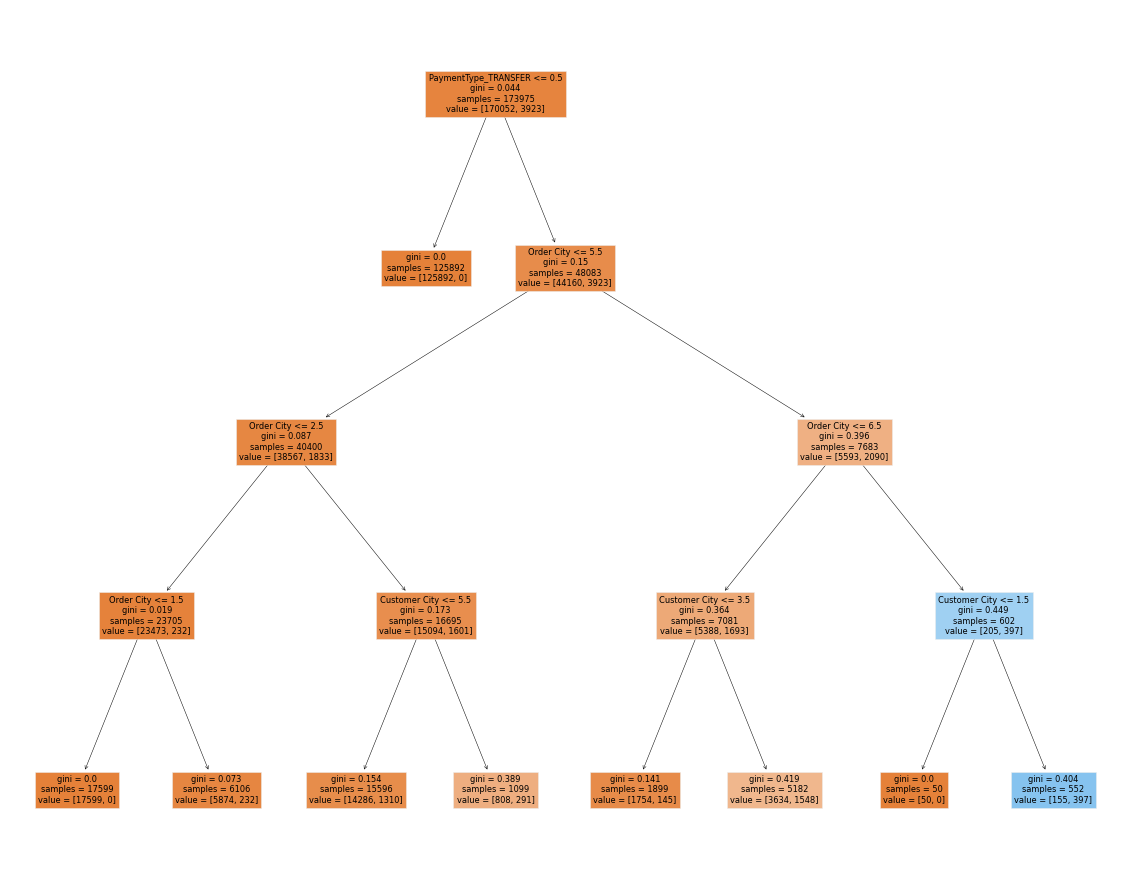

In [5]:
tree = DecisionTreeClassifier(max_depth = 4).fit( X, y )

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree, feature_names = X.columns, filled = True);

---
# Random Forest Model

In [6]:
RFC = RandomForestClassifier()

#grid search
grid_values = {
    'criterion':['gini', 'log_loss'],
    'n_estimators':[300, 400, 500, 600]
}
RFC_gridsearch = GridSearchCV(RFC, param_grid = grid_values, scoring = 'precision', cv=5)
RFC_gridsearch.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'log_loss'],
                         'n_estimators': [300, 400, 500, 600]},
             scoring='precision')

In [7]:
#grid search CV results
pd.DataFrame(RFC_gridsearch.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,20.136387,0.653236,0.729690,0.014914,log_loss,500,"{'criterion': 'log_loss', 'n_estimators': 500}",0.896774,0.905405,0.922078,0.937500,0.902098,0.912771,0.014981,1
0,14.452819,0.607413,0.621608,0.003758,gini,300,"{'criterion': 'gini', 'n_estimators': 300}",0.888199,0.898649,0.918239,0.929936,0.891892,0.905383,0.016067,2
2,24.378436,0.831535,1.070808,0.074076,gini,500,"{'criterion': 'gini', 'n_estimators': 500}",0.898089,0.872611,0.913580,0.924051,0.909722,0.903611,0.017584,3
3,27.115285,0.869788,0.958032,0.073811,gini,600,"{'criterion': 'gini', 'n_estimators': 600}",0.900621,0.880000,0.907975,0.932099,0.895425,0.903224,0.017107,4
5,16.556973,0.135807,0.590249,0.017897,log_loss,400,"{'criterion': 'log_loss', 'n_estimators': 400}",0.886076,0.902778,0.905797,0.932432,0.885714,0.902560,0.017079,5


In [8]:
RFC = RandomForestClassifier(criterion='log_loss',n_estimators=400)
RFC.fit(X_train, y_train)
print('Train Accuracy: ', RFC.score(X_train, y_train))
print('Test Accuracy: ', RFC.score(X_test, y_test))

Train Accuracy:  0.999983577211739
Test Accuracy:  0.9824880731132527


In [9]:
y_pred = RFC.predict(X_test)
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[  312,    35],
       [  879, 50967]])

In [10]:
RFC_results = model_results(mod=RFC, label='Random Forest Classifier', X_test = X_test, y_test=y_test)
RFC_results

,Random Forest Classifier
Precision,0.899135
Recall,0.261965
Accuracy,0.982488
ROC AUC,0.630639


In [11]:
X_test.shape

(52193, 39)

In [12]:
(y_test == 0).sum()

51002

In [ ]:
'''
The random forest model correctly predicts 306 fraud cases out of 1191 in the test set, and only incorrectly
classifies 33 non-fraud cases as fraud. If the company were to automatically disregard these 306 orders marked as 
fraud by, they would save $X, and would only lose $X on real orders presumed to be fraud. The 885 cases of fraud
which are not detected as fraud can be assessed by human judgement.

This model identifies 25.7% of fraud orders, while only misidentifying 0.065% of legitamite orders as fraud.

This model roughly identifies over 10 fraud orders for every order misclassified as fraud. At this rate,
implementing this model would certainly save the company money.
'''

---
# Boosting Model

In [13]:
GBC = GradientBoostingClassifier()

#grid search
grid_values = {
    'learning_rate':[.1, .5],
    'n_estimators':[25, 50, 100],
    'max_depth':[1]
}
GBC_gridsearch = GridSearchCV(GBC, param_grid=grid_values, scoring=['roc_auc','precision'], refit='precision', cv=5)
GBC_gridsearch.fit(X_train, y_train.values.ravel())

/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [1],
                         'n_estimators': [25, 50, 100]},
             refit='precision', scoring=['roc_auc', 'precision'])

In [ ]:
# this warning is happening because the model doesn't predict any positives in the cv case, because the cv case
#has less data and there are already so few positive cases.

In [14]:
#results
pd.DataFrame(GBC_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_roc_auc,split1_test_roc_auc,...,std_test_roc_auc,rank_test_roc_auc,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
1,2.096800,0.139230,0.043702,0.003484,0.1,1,50,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.960624,0.960882,...,0.001145,5,0.727273,1.000000,0.892857,0.916667,0.846154,0.876590,0.089803,1
2,3.851762,0.222350,0.052267,0.001339,0.1,1,100,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.964242,0.964686,...,0.001224,4,0.649351,0.800000,0.761905,0.835821,0.652778,0.739971,0.076271,2
5,3.722592,0.019164,0.055572,0.001831,0.5,1,100,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.965789,0.965166,...,0.001501,1,0.594203,0.625954,0.624060,0.702479,0.584507,0.626241,0.041437,3
4,1.929721,0.018134,0.041043,0.000669,0.5,1,50,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.965661,0.965442,...,0.001430,2,0.595588,0.598425,0.639706,0.672000,0.577181,0.616580,0.034435,4
3,1.048392,0.043631,0.034532,0.000732,0.5,1,25,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.964758,0.964705,...,0.001285,3,0.572327,0.614286,0.626761,0.666667,0.569536,0.609915,0.036241,5


In [15]:
GBC = GradientBoostingClassifier(learning_rate=.1, n_estimators=50,max_depth=1)
GBC.fit(X_train, y_train)
y_pred = GBC.predict(X_test)
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   58,    11],
       [ 1133, 50991]])

In [16]:
print('Train Accuracy: ', GBC.score(X_train, y_train))
print('Test Accuracy: ', GBC.score(X_test, y_test))

Train Accuracy:  0.978223382765926
Test Accuracy:  0.9780813519054279


In [17]:
GBC_results = model_results(mod=GBC, label='GBC', X_test = X_test, y_test=y_test)
GBC_results

,GBC
Precision,0.840580
Recall,0.048699
Accuracy,0.978081
ROC AUC,0.524241


---

# Logistic Regression Model
not the right model for this problem

In [18]:
# scale data
sc = StandardScaler()
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

sc.fit(X) #fit over full dataset

X_train_sc.loc[:,:] = sc.transform(X_train_sc)
X_test_sc.loc[:,:] = sc.transform(X_test_sc)

In [19]:
#grid search
LR = LogisticRegression(max_iter = 4000)

grid_values = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear', 'saga'],
    'tol':[1, .1, .01]
}
LR_gridsearch = GridSearchCV(LR, param_grid=grid_values, scoring=['roc_auc','precision'], refit='precision', cv=5)
LR_gridsearch.fit(X_train_sc, y_train.values.ravel())

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=4000),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga'],
                         'tol': [1, 0.1, 0.01]},
             refit='precision', scoring=['roc_auc', 'precision'])

In [20]:
#results
pd.DataFrame(LR_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,param_tol,params,split0_test_roc_auc,split1_test_roc_auc,...,std_test_roc_auc,rank_test_roc_auc,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
6,0.279519,0.014984,0.024279,0.001513,l2,liblinear,1,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.963472,0.961678,...,0.001425,12,0.916667,1.000000,0.785714,0.866667,0.857143,0.885238,0.070989,1
0,0.472761,0.029359,0.033843,0.006153,l1,liblinear,1,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.963581,0.962845,...,0.001296,11,1.000000,0.605263,0.545455,0.508197,0.574074,0.646598,0.179581,2
10,0.130457,0.008581,0.017927,0.001493,l2,saga,0.1,"{'penalty': 'l2', 'solver': 'saga', 'tol': 0.1}",0.964535,0.963615,...,0.001156,7,0.596491,0.591398,0.611650,0.606742,0.615385,0.604333,0.009059,3
3,0.090201,0.004258,0.016039,0.000745,l1,saga,1,"{'penalty': 'l1', 'solver': 'saga', 'tol': 1}",0.964179,0.962657,...,0.001317,10,0.626374,0.546392,0.628319,0.622642,0.594828,0.603711,0.031119,4
1,0.989583,0.231438,0.034916,0.006636,l1,liblinear,0.1,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.964529,0.963627,...,0.001191,5,0.586207,0.574468,0.626374,0.608696,0.600000,0.599149,0.017943,5


In [21]:
LR = LogisticRegression(penalty='l2', tol=1, solver='liblinear')
LR.fit(X_train_sc, y_train)

y_pred = LR.predict(X_test_sc)
precision_score(y_test, y_pred)

0.9117647058823529

In [22]:
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   31,     3],
       [ 1160, 50999]])

In [23]:
model_results(LR, 'Logistic Regression', X_test=X_test_sc, y_test=y_test)

,Logistic Regression
Precision,0.911765
Recall,0.026029
Accuracy,0.977717
ROC AUC,0.512985


In [24]:
#grid search 2.0
LR = LogisticRegression(max_iter = 4000)

grid_values = {
    'penalty':['l1', 'l2'],
    'solver':['liblinear'],
    'tol':[1.5, 1.25, 1, .75, .5]
}
LR_gridsearch = GridSearchCV(LR, param_grid=grid_values, scoring=['roc_auc','precision'], refit='precision', cv=5)
LR_gridsearch.fit(X_train_sc, y_train.values.ravel())

/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=4000),
             param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'],
                         'tol': [1.5, 1.25, 1, 0.75, 0.5]},
             refit='precision', scoring=['roc_auc', 'precision'])

In [25]:
#results 2.0
pd.DataFrame(LR_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,param_tol,params,split0_test_roc_auc,split1_test_roc_auc,...,std_test_roc_auc,rank_test_roc_auc,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
1,0.309178,0.026533,0.031792,0.003030,l1,liblinear,1.25,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.963665,0.962475,...,0.001151,5,1.000000,1.0,1.000000,0.888889,0.850000,0.947778,0.065130,1
6,0.265950,0.008653,0.024558,0.001447,l2,liblinear,1.25,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.963472,0.961678,...,0.001425,7,0.916667,1.0,0.785714,0.866667,0.857143,0.885238,0.070989,2
7,0.288431,0.031102,0.025276,0.002060,l2,liblinear,1,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.963472,0.961678,...,0.001425,7,0.916667,1.0,0.785714,0.866667,0.857143,0.885238,0.070989,2
8,0.261863,0.004809,0.023786,0.000176,l2,liblinear,0.75,"{'penalty': 'l2', 'solver': 'liblinear', 'tol'...",0.963472,0.961678,...,0.001425,7,0.916667,1.0,0.785714,0.866667,0.857143,0.885238,0.070989,2
0,0.299543,0.038750,0.027883,0.003799,l1,liblinear,1.5,"{'penalty': 'l1', 'solver': 'liblinear', 'tol'...",0.964261,0.961347,...,0.001758,6,0.605263,1.0,0.555556,0.842105,0.833333,0.767251,0.164437,5


In [26]:
LR = LogisticRegression(penalty='l1', tol=1.25, solver='liblinear')
LR.fit(X_train_sc, y_train)

y_pred = LR.predict(X_test_sc)
precision_score(y_test, y_pred)

0.7777777777777778

In [27]:
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   35,    10],
       [ 1156, 50992]])

In [44]:
LR_results = model_results(LR, 'Logistic Regression', X_test=X_test_sc, y_test=y_test)
LR_results

,Logistic Regression
Precision,0.777778
Recall,0.029387
Accuracy,0.977660
ROC AUC,0.514595


- The logistic regression model does not predict a significant amount of fraud orders, and is not a prodcutive model for predicting fraud.

---
# KNN Model

In [29]:
# K Nearest Neighbors
KNN = KNeighborsClassifier()

#grid search
grid_values = {
    'n_neighbors':[1, 3, 5, 7, 10, 15, 20]
}
KNN_gridsearch = GridSearchCV(KNN, param_grid = grid_values, scoring = ['precision','roc_auc'], refit=False, cv=5)
KNN_gridsearch.fit(X_train_sc, y_train.values.ravel())

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 10, 15, 20]}, refit=False,
             scoring=['precision', 'roc_auc'])

In [30]:
pd.DataFrame(KNN_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,...,std_test_precision,rank_test_precision,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
6,0.032239,0.002691,5.480479,0.145227,20,{'n_neighbors': 20},0.608696,0.833333,0.777778,0.692308,...,0.107283,1,0.912014,0.914038,0.926469,0.934189,0.915252,0.920392,0.008536,1
5,0.031285,0.002361,5.282773,0.141795,15,{'n_neighbors': 15},0.594595,0.750000,0.736842,0.696970,...,0.096854,2,0.897503,0.901712,0.918485,0.923200,0.903147,0.908809,0.010109,2
4,0.029718,0.000260,5.113044,0.065677,10,{'n_neighbors': 10},0.596491,0.740741,0.678571,0.681818,...,0.046475,3,0.890701,0.888230,0.892527,0.906320,0.884034,0.892362,0.007537,3
3,0.029934,0.000745,5.116201,0.067722,7,{'n_neighbors': 7},0.514085,0.635659,0.585938,0.585034,...,0.045913,4,0.868657,0.871094,0.874343,0.887286,0.868369,0.873950,0.007005,4
2,0.029974,0.001090,5.108413,0.051641,5,{'n_neighbors': 5},0.540816,0.563107,0.607955,0.540670,...,0.031641,5,0.847576,0.849010,0.848448,0.861162,0.849422,0.851123,0.005057,5


In [31]:
KNN = KNeighborsClassifier(n_neighbors=15)
KNN.fit(X_train_sc, y_train)

y_pred = KNN.predict(X_test_sc)
confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   60,    29],
       [ 1131, 50973]])

In [32]:
print('Train Accuracy: ', KNN.score(X_train_sc, y_train))
print('Test Accuracy: ', KNN.score(X_test_sc, y_test))

Train Accuracy:  0.9792908640028904
Test Accuracy:  0.9777747973866228


In [42]:
KNN_results = model_results(mod=KNN, label='KNN', X_test = X_test_sc, y_test=y_test)
KNN_results

,KNN
Precision,0.674157
Recall,0.050378
Accuracy,0.977775
ROC AUC,0.524905


- KNN model is not precise enough to be considered.

---
# SVMC Model

In [36]:
SVMC = SVC()

#grid search
grid_values = {
    'C':[1.0],
    'kernel':['linear','rbf']
}
SVMC_gridsearch = GridSearchCV(SVMC, param_grid = grid_values, scoring = ['precision','roc_auc'], refit=False, cv=5)
SVMC_gridsearch.fit(X_train_sc, y_train.values.ravel())

/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/willfitzhugh/Library/Python/3.9/lib/python/site-

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1.0], 'kernel': ['linear', 'rbf']}, refit=False,
             scoring=['precision', 'roc_auc'])

In [37]:
pd.DataFrame(SVMC_gridsearch.cv_results_).sort_values(by='rank_test_precision').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_precision,split1_test_precision,split2_test_precision,...,std_test_precision,rank_test_precision,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
1,81.036946,7.865702,40.537654,1.487490,1.0,rbf,"{'C': 1.0, 'kernel': 'rbf'}",0.833333,1.0,1.0,...,0.133333,1,0.949094,0.951517,0.955217,0.956432,0.949228,0.952298,0.003030,1
0,283.168761,53.379512,8.630141,1.054595,1.0,linear,"{'C': 1.0, 'kernel': 'linear'}",0.000000,0.0,0.0,...,0.000000,2,0.928342,0.906590,0.918346,0.919254,0.905135,0.915534,0.008648,2


In [38]:
SVMC = SVC()
SVMC.fit(X_train_sc, y_train)

y_pred = SVMC.predict(X_test_sc)

confusion_matrix(y_pred, y_test, labels=[1,0])

array([[   17,     1],
       [ 1174, 51001]])

In [39]:
print('Train Accuracy: ', SVMC.score(X_train_sc, y_train))
print('Test Accuracy: ', SVMC.score(X_test_sc, y_test))

Train Accuracy:  0.978206959977665
Test Accuracy:  0.9774874025252428


In [40]:
SVMC_results = model_results(mod=SVMC, label='SVMC', X_test = X_test_sc, y_test=y_test)
SVMC_results

,SVMC
Precision,0.944444
Recall,0.014274
Accuracy,0.977487
ROC AUC,0.507127


---
# Summarize Results:


In [45]:
final_results = pd.concat([RFC_results, GBC_results, KNN_results, SVMC_results, LR_results], axis = 1)
final_results

,Random Forest Classifier,GBC,KNN,SVMC,Logistic Regression
Precision,0.899135,0.840580,0.674157,0.944444,0.777778
Recall,0.261965,0.048699,0.050378,0.014274,0.029387
Accuracy,0.982488,0.978081,0.977775,0.977487,0.977660
ROC AUC,0.630639,0.524241,0.524905,0.507127,0.514595


In [ ]:
#bar chart